In [1]:
!pip install prophet # optional, this is to play with fbprophet (https://facebook.github.io/prophet/docs/quick_start.html#python-api)
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

from matplotlib import style
from datetime import datetime, timedelta

matplotlib.style.use('grayscale')

## Index overview

### Getting the data

Freely available structured data for the greek stock market indices are not easy to come by - especially nowadays with the excellent `investpy` library being [out of commission](https://github.com/alvarobartt/investpy/issues/600) at least for the foreseeable future.

Fortunately several greek finance online publications maintain tables of daily prices and OHLC data. In this instace we use a csv file published by capital.gr (link [link text](https://www.capital.gr/finance/historycloses/ftse?page=1)) which is updated a couple hours after market close time (~ 19:00 - 20:00 EET).

The data available cover the period from 01/01/1995 - today, however we are focusing on the the index evolution since 2017.



In [3]:
# get FTSE25 data from capital.gr (https://www.capital.gr/finance/historycloses/ftse?page=1)
# note that the key param of the url below might be different - check it against the link above!
data = pd.read_csv('https://www.capital.gr/finance/quotes/exporthistorycloses?symbol=ftse&key=-1491648092', skiprows = 1, decimal=",")  

# remove columns we are not using
del data['ΜΕΤ.%']
del data['Τζίρος']

# convert date to date format
data['Ημ/νία'] = pd.to_datetime(data['Ημ/νία'], format="%d/%m/%Y")

# rename columns to en
data.columns = ['date', 'close', 'open', 'high', 'low', 'volume']

# make date index
data.set_index('date', inplace = True)

# convert volume column from string to float
data['volume'] = data['volume'].str.replace(".","").astype(float)

# rearrange columns
data = data[['open', 'high', 'low', 'close', 'volume']]

# keep data from 01/01/2017 and sort ascending
data = data[(data.index > "2017-01-01")].sort_index(ascending=True)

# check for missing values (this will be included in the QC section of the final pipeline for the daily ingested data along with the other quality checks)
data.isnull().sum()

# view a sample
print(data)

               open     high      low      close      volume
date                                                        
2017-01-02  1741.46  1753.04  1740.67  1744.9400  18213258.0
2017-01-03  1750.98  1778.75  1745.83  1769.6900  68663545.0
2017-01-04  1778.02  1780.06  1763.24  1773.8400  52684044.0
2017-01-05  1773.71  1773.94  1752.64  1773.9400  66179243.0
2017-01-09  1773.62  1773.81  1751.83  1769.7400  31669813.0
...             ...      ...      ...        ...         ...
2022-09-26  1908.19  1927.38  1881.06  1904.2000  13750969.0
2022-09-27  1923.99  1939.19  1918.11  1918.1100  18292863.0
2022-09-28  1902.70  1919.46  1876.47  1899.5700  19235792.0
2022-09-29  1899.99  1913.71  1891.97  1894.0699  13045188.0
2022-09-30  1898.92  1914.45  1897.85  1904.4500  19823453.0

[1425 rows x 5 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


### Data processing
Create columns for:


1.   daily absolute percentage change,
2.   standard deviation of return,
3.   daily, monthly and annualized historical volatility.



In [ ]:
#calculate daily absolute daily return, logarithmic return, and weekly historical volatility
data['abs_return'] = 100*data['close'].pct_change()
data['log_return'] = 100* (np.log(data['close'] / data['close'].shift(1)))
data['day_vol'] = data['log_return'].std()
data['month_vol'] = data['log_return'].rolling(window = 21).std()*np.sqrt(21)
data['annual_vol'] = data['log_return'].rolling(window = 252).std()*np.sqrt(252)

In [ ]:
# Calculate daily std of return
daily_volatility = data['log_return'].std()

# Convert daily volatility to monthly volatility
monthly_volatility  = np.sqrt(21) * daily_volatility

# Convert daily volatility to annual volatility
annual_volatility = np.sqrt(252) * daily_volatility


print(f'Daily volatility: {round(daily_volatility,2)}%')
print(f'\nMonthly volatility: {round(monthly_volatility,2)}%')
print(f'\nAnnualized volatility: {round(annual_volatility,2)}%')

Daily volatility: 1.62%

Monthly volatility: 7.44%

Annualized volatility: 25.77%


### Visualizations

In [ ]:
# line plot
def generatePlot(data, xlabel, ylabel, title, subtitle):

    fig, ax = plt.subplots(figsize=(16,8))

    sns.lineplot(
        alpha = 0.75,
        data = data,
        ax = ax
    )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    locator = mdates.MonthLocator(bymonth=[4,7,10])
    ax.xaxis.set_minor_locator(locator)
    ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

    ax.set_xlim([datetime.date(data.index.min() - timedelta(days = 30)), datetime.date(data.index.max() + timedelta(days = 30))])

    ax.text(x=0.5, y=1.1, s = title, fontsize=30, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    ax.text(x=0.5, y=1.05, s = subtitle, fontsize=18, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
    fig.tight_layout()
    plt.show()

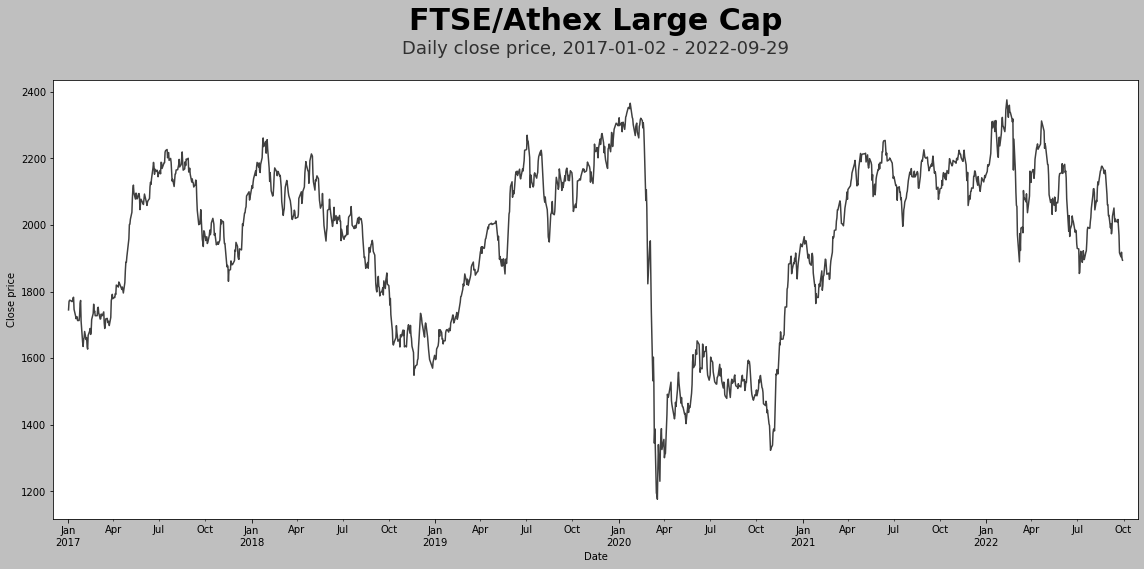

In [ ]:
generatePlot(data['close'], 'Date', 'Close price', 'FTSE/Athex Large Cap', f"Daily close price, {datetime.date(data.index.min())} - {datetime.date(data.index.max())}")

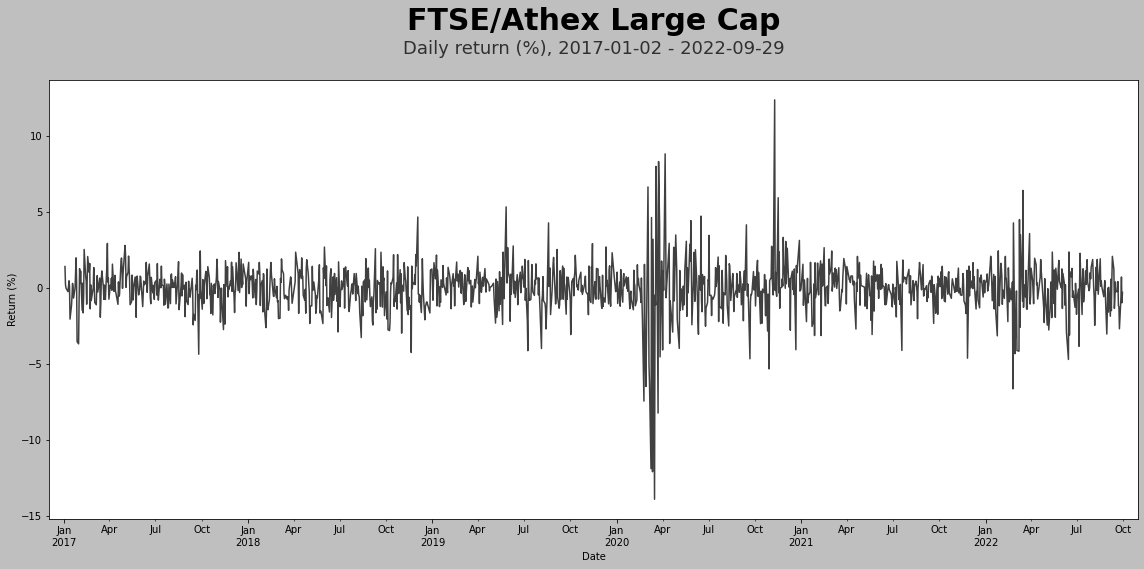

In [ ]:
generatePlot(data['abs_return'], 'Date', 'Return (%)', 'FTSE/Athex Large Cap', f"Daily return (%), {datetime.date(data.index.min())} - {datetime.date(data.index.max())}")

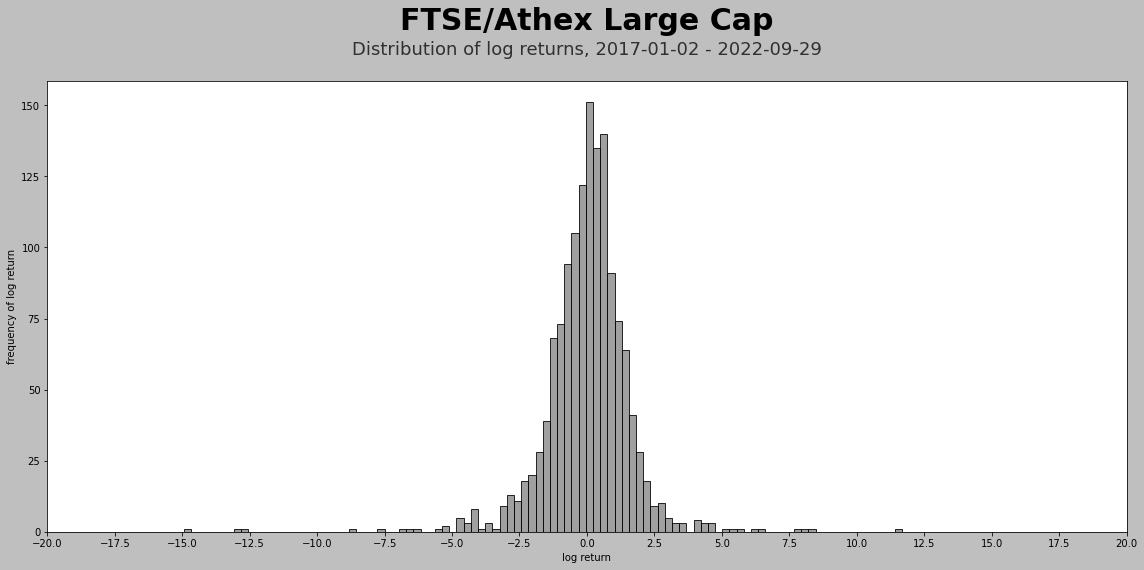

In [ ]:
# histogram of log returns

matplotlib.style.use('grayscale')

fig, ax = plt.subplots(figsize=(16,8))

sns.histplot(
    alpha=0.75,
    data=data['log_return'],
    bins=100,
    ax=ax
)

ax.set_xlabel('log return')
ax.set_ylabel('frequency of log return')

ax.set_yticks(np.arange(0, 175, 25))
ax.set_xticks(np.arange(-20, 22.5, 2.5))

ax.text(x=0.5, y=1.1, s='FTSE/Athex Large Cap', fontsize=30, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=f"Distribution of log returns, {datetime.date(data.index.min())} - {datetime.date(data.index.max())}", fontsize=18, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout()
plt.show()

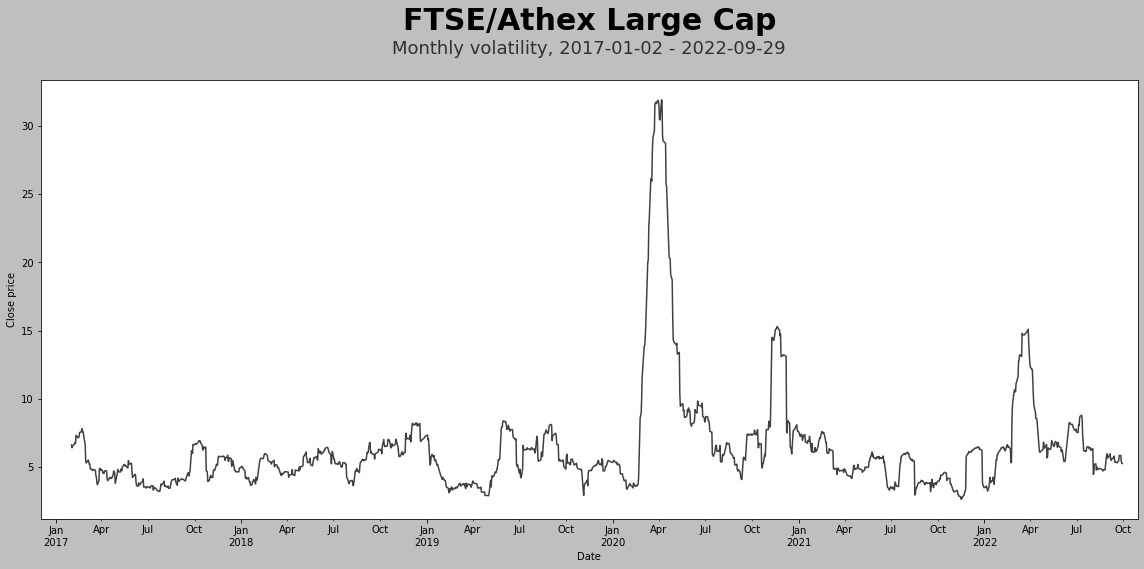

In [ ]:
generatePlot(data['month_vol'], 'Date', 'Percent (%)', 'FTSE/Athex Large Cap', f"Monthly volatility, {datetime.date(data.index.min())} - {datetime.date(data.index.max())}")

## Index constituents overview
Notes:
1.   We consider the same list of 25 constituents over the entire time period. The index is revised on a semiannual basis however with very few changes over the last years (~ 0 -1 changes every review period). The list of announcements with the additions / removals are [here](https://www.athexgroup.gr/el/web/guest/index-information-announcements).
2.   TBD



In [3]:
ftseStonks = {'ΑΛΦΑ':'ALPHA.AT',
              'ΑΔΜΗΕ':'ADMIE.AT',
              'ΑΡΑΙΓ':'AEGN.AT',
              'ΜΠΕΛΑ':'BELA.AT',
              'ΠΕΙΡ':'TPEIR.AT',
              'ΔΕΗ':'PPC.AT',
              'ΕΕΕ':'EEE.AT',
              'ΕΛΧΑ':'ELHA.AT',
              'ΕΥΡΩΒ':'EUROB.AT',
              'ΕΥΔΑΠ':'EYDAP.AT',
              'ΕΛΛΑΚΤΩΡ':'ELLAKTOR.AT',
              'ΕΛΠΕ':'ELPE.AT',
              'ΓΕΚΤΕΡΝΑ':'GEKTERNA.AT',
              'ΚΟΥΕΣ':'QUEST.AT',
              'ΛΑΜΔΑ':'LAMDA.AT',
              'ΜΟΗ':'MOH.AT',
              'ΜΥΤΙΛ':'MYTIL.AT',
              'ΕΤΕ':'ETE.AT',
              'ΟΛΠ':'PPA.AT',
              'ΟΠΑΠ':'OPAP.AT',
              'ΟΤΕ':'HTO.AT',
              'ΣΑΡ':'SAR.AT',
              'ΤΕΝΕΡΓ':'TENERGY.AT',
              'TITC':'TITC.AT',
              'ΒΙΟ':'VIO.AT'}

In [6]:
# we are interested only in the closing price, we fetch the last three years worth of data (practially right before the COVID crash).
tickers = yf.Tickers(list(ftseStonks.values()))
data = tickers.download(period='3y',interval='1d', actions=True,auto_adjust=True)['Close']

[*********************100%***********************]  25 of 25 completed


In [7]:
# have a look at a sample of the stocks
data.tail(5)

,ADMIE.AT,AEGN.AT,ALPHA.AT,BELA.AT,EEE.AT,ELHA.AT,ELLAKTOR.AT,ELPE.AT,ETE.AT,EUROB.AT,...,MYTIL.AT,OPAP.AT,PPA.AT,PPC.AT,QUEST.AT,SAR.AT,TENERGY.AT,TITC.AT,TPEIR.AT,VIO.AT
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-26,1.690,4.675,0.8470,13.50,21.850000,1.360,1.582,6.05,3.028,0.8702,...,13.47,12.15,14.20,5.280,4.050,5.80,15.440000,10.76,1.1055,3.405
2022-09-27,1.662,4.600,0.8470,13.42,22.049999,1.370,1.584,6.10,3.090,0.8802,...,13.67,12.13,14.12,5.320,4.070,6.00,16.299999,10.82,1.1075,3.460
2022-09-28,1.670,4.485,0.8400,13.70,21.150000,1.368,1.570,6.14,3.008,0.8600,...,13.56,12.14,14.00,5.280,4.120,6.02,16.480000,10.80,1.0700,3.390
2022-09-29,1.630,4.450,0.8216,13.96,21.100000,1.320,1.580,6.25,3.030,0.8522,...,13.90,12.01,13.90,5.165,4.125,6.00,16.350000,10.70,1.0300,3.390
2022-09-30,1.620,4.420,0.8060,13.65,21.100000,1.340,1.594,6.26,3.026,0.8560,...,13.99,12.28,13.88,5.200,4.180,6.09,16.500000,10.84,1.0370,3.385


In [14]:
# stack to multi index
t = data.stack()

# rename 'value' column
t.name = 'Close'

# save series to data frame
t = t.to_frame()

test = strcat('x.',indicator)
# calculate ema 50
t2 = t.groupby(level=1).apply(lambda x: x.ewm(span=50).mean())

# merge dataframes
t3 = pd.merge(t, t2, left_index=True, right_index=True)

# unstack
t4 = t3.reset_index(level=[0,1])

# create bool column to store whether price is above ema50
comparison_column = np.where(t4["Close_y"] < t4["Close_x"], True, False)
t4["above"] = comparison_column

# delete "Close_y" and "Close_X" prices as we don't need them - they store the actual close price and the EMA50 price
del t4["Close_x"]
del t4["Close_y"]

# group by date
t4 = t4.groupby('Date')['above'].mean()*100

# save series to data frame
t4 = t4.to_frame()

# keep data from 01/01/2020 and beyond
t4 = t4[t4.index > '2020-01-01']

# look at a sample of the result
t4.tail(10)

,above
Date,
2022-09-19,24.0
2022-09-20,28.0
2022-09-21,12.0
2022-09-22,8.0
2022-09-23,8.0
2022-09-26,4.0
2022-09-27,8.0
2022-09-28,4.0
2022-09-29,0.0


In [16]:
indicator = 'ewm'
'x.'+indicator

'x.ewm'

In [30]:
def calculateAverages(dataset, dateFrom, indicator, span):
    # stack to multi index
    t = dataset.stack()    

    # rename 'value' column
    t.name = 'Close'

    # save series to data frame
    t = t.to_frame()

    # calculate indicator
    t2 = t.groupby(level = 1).apply(lambda x: x.ewm(span = span).mean())

    # merge dataframes
    t3 = pd.merge(t, t2, left_index=True, right_index=True)

    # unstack
    t4 = t3.reset_index(level = [0,1])

    # create bool column to store whether price is above ema50
    comparison_column = np.where(t4["Close_y"] < t4["Close_x"], True, False)
    t4["above"] = comparison_column

    # delete "Close_y" and "Close_X" prices as we don't need them - they store the actual close price and the EMA50 price
    del t4["Close_x"]
    del t4["Close_y"]

    # group by date
    t4 = t4.groupby('Date')['above'].mean()*100

    t4.name = 'stocks above ' + indicator+ str(span)

    # save series to data frame
    t4 = t4.to_frame()

    # keep data from 01/01/2020 and beyond
    t4 = t4[t4.index > dateFrom] #'2020-01-01'
    
    # return resulting dataframe
    return t4

In [31]:
calculateAverages(data, '2020-01-01', 'ewm', 50)

,stocks above ewm50
Date,
2020-01-02,100.0
2020-01-03,80.0
2020-01-07,88.0
2020-01-08,64.0
2020-01-09,80.0
...,...
2022-09-26,4.0
2022-09-27,8.0
2022-09-28,4.0
